## Integrated Approach

## Kết hợp kết quả 3 methods: RWR, DWNN-RLS, GMNN2CD
Chạy dataset 3
=> Kết quả tốt hơn từng phương pháp riêng lẻ

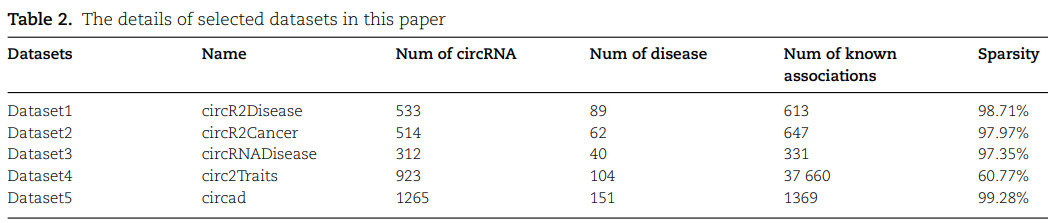




In [1]:
import numpy as np
import h5py
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import sortscore
# import sklearn.cluster as sc
from MakeSimilarityMatrix import MakeSimilarityMatrix#计算高斯核相似性

import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse

import time

from sklearn.preprocessing import minmax_scale
import pandas as pd

In [2]:
with h5py.File('./Data/circRNA_disease_from_circRNADisease/association.h5', 'r') as hf:
        circrna_disease_matrix = hf['infor'][:]

In [3]:
# Đọc dữ liệu từ các file CSV
gmnn_matrix = np.genfromtxt('GMNN2CD_result.csv', delimiter=',')
rwr_matrix = np.genfromtxt('RWR_result.csv', delimiter=',')
dwnn_matrix = np.genfromtxt('DWNN-RLS_result.csv', delimiter=',')

In [4]:
dwnn_matrix = np.maximum(dwnn_matrix, 0)
np.min(dwnn_matrix)

0.0

In [5]:
prediction_matrix = (gmnn_matrix + rwr_matrix + dwnn_matrix)/3
df = pd.DataFrame(prediction_matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.619717,0.016779,0.001465,0.001185,0.001005,0.001316,0.005730,0.001059,0.001065,0.001065,...,0.001140,0.000966,0.001619,0.001315,0.005726,0.001373,0.001461,0.001257,0.001104,0.033517
1,0.027727,0.588925,0.003736,0.003805,0.003019,0.004932,0.011156,0.002401,0.002412,0.002482,...,0.002731,0.002536,0.002595,0.003059,0.007706,0.004085,0.003829,0.003206,0.002465,0.034561
2,0.619618,0.016686,0.001460,0.001181,0.001002,0.001308,0.005685,0.001056,0.001061,0.001062,...,0.001136,0.000962,0.001615,0.001309,0.005697,0.001365,0.001456,0.001251,0.001101,0.033517
3,0.616294,0.017345,0.001621,0.001436,0.001274,0.001579,0.006105,0.001336,0.001361,0.001362,...,0.001300,0.001124,0.001137,0.001588,0.006045,0.001643,0.001733,0.001481,0.001381,0.033808
4,0.619680,0.016744,0.001463,0.001184,0.001003,0.001313,0.005714,0.001057,0.001063,0.001063,...,0.001138,0.000964,0.001617,0.001311,0.005716,0.001370,0.001459,0.001253,0.001103,0.033517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.015848,0.009397,0.003083,0.002275,0.001533,0.005742,0.008353,0.001566,0.001589,0.001573,...,0.001557,0.001349,0.001334,0.001833,0.589135,0.005600,0.002472,0.001675,0.001721,0.033817
308,0.626310,0.016306,0.001197,0.000983,0.000751,0.001040,0.005319,0.000893,0.000899,0.000897,...,0.001044,0.000865,0.001517,0.001131,0.003788,0.001046,0.001220,0.001117,0.000962,0.033410
309,0.619791,0.016837,0.001468,0.001188,0.001007,0.001320,0.005754,0.001061,0.001067,0.001067,...,0.001142,0.000967,0.001621,0.001316,0.005739,0.001377,0.001464,0.001258,0.001106,0.033517
310,0.004916,0.004778,0.003464,0.002371,0.001060,0.005798,0.005376,0.001306,0.001400,0.001376,...,0.001688,0.001471,0.001320,0.001449,0.008112,0.005796,0.002556,0.001440,0.001542,0.033648


accuracy:0.4936,recall:0.9886,precision:0.0267,F1:0.0458
AUC:0.9891,AUPR:0.2229


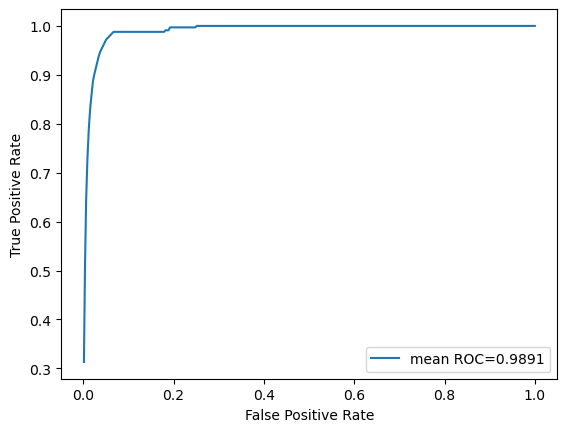

In [12]:
index_tuple = (np.where(circrna_disease_matrix == 1))
one_list = list(zip(index_tuple[0], index_tuple[1]))
random.shuffle(one_list)
split = math.ceil(len(one_list) / 5)

all_tpr = []
all_fpr = []
all_recall = []
all_precision = []
all_accuracy = []
all_F1 = []

# 5-fold start
for i in range(0, len(one_list), split):
    test_index = one_list[i:i + split]
    new_circrna_disease_matrix = circrna_disease_matrix.copy()
    
    for index in test_index:
        new_circrna_disease_matrix[index[0], index[1]] = 0
    roc_circrna_disease_matrix = new_circrna_disease_matrix + circrna_disease_matrix
    rel_matrix = new_circrna_disease_matrix
    aa = prediction_matrix.shape
    bb = roc_circrna_disease_matrix.shape
    zero_matrix = np.zeros((prediction_matrix.shape[0], prediction_matrix.shape[1]))

    score_matrix_temp = prediction_matrix.copy()
    score_matrix = score_matrix_temp + zero_matrix
    minvalue = np.min(score_matrix)
    score_matrix[np.where(roc_circrna_disease_matrix == 2)] = minvalue - 20#？
    sorted_circrna_disease_matrix, sorted_score_matrix, sort_index = sortscore.sort_matrix(score_matrix,roc_circrna_disease_matrix)

    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    F1_list = []
    for cutoff in range(sorted_circrna_disease_matrix.shape[0]):
        P_matrix = sorted_circrna_disease_matrix[0:cutoff + 1, :]
        N_matrix = sorted_circrna_disease_matrix[cutoff + 1:sorted_circrna_disease_matrix.shape[0] + 1, :]
        TP = np.sum(P_matrix == 1)
        FP = np.sum(P_matrix == 0)
        TN = np.sum(N_matrix == 0)
        FN = np.sum(N_matrix == 1)
        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        recall_list.append(recall)
        precision_list.append(precision)
        accuracy = (TN + TP) / (TN + TP + FN + FP)
        F1 = (2 * TP) / (2*TP + FP + FN)
        if (2*TP + FP + FN)==0 :
            F1 = 0
        F1_list.append(F1)
        accuracy_list.append(accuracy)

    tpr_arr_epoch = np.array(tpr_list)
    fpr_arr_epoch = np.array(fpr_list)
    recall_arr_epoch = np.array(recall_list)
    precision_arr_epoch = np.array(precision_list)
    accuracy_arr_epoch = np.array(accuracy_list)
    F1_arr_epoch = np.array(F1_list)
    
    all_tpr.append(tpr_list)
    all_fpr.append(fpr_list)
    all_recall.append(recall_list)
    all_precision.append(precision_list)
    all_accuracy.append(accuracy_list)
    all_F1.append(F1_list)

tpr_arr = np.array(all_tpr)
fpr_arr = np.array(all_fpr)
recall_arr = np.array(all_recall)
precision_arr = np.array(all_precision)
accuracy_arr = np.array(all_accuracy)
F1_arr = np.array(all_F1)

mean_cross_tpr = np.mean(tpr_arr, axis=0)  # axis=0
mean_cross_fpr = np.mean(fpr_arr, axis=0)
mean_cross_recall = np.mean(recall_arr, axis=0)
mean_cross_precision = np.mean(precision_arr, axis=0)
mean_cross_accuracy = np.mean(accuracy_arr, axis=0)
mean_accuracy = np.mean(np.mean(accuracy_arr, axis=1), axis=0)
mean_recall = np.mean(np.mean(recall_arr, axis=1), axis=0)
mean_precision = np.mean(np.mean(precision_arr, axis=1), axis=0)
mean_F1 = np.mean(np.mean(F1_arr, axis=1), axis=0)
print("accuracy:%.4f,recall:%.4f,precision:%.4f,F1:%.4f"%(mean_accuracy, mean_recall, mean_precision, mean_F1))

roc_auc = np.trapz(mean_cross_tpr, mean_cross_fpr)
AUPR = np.trapz(mean_cross_precision, mean_cross_recall)

print("AUC:%.4f,AUPR:%.4f"%(roc_auc, AUPR))

with h5py.File('./PlotFigure/GMNN2CD_circRNADisease_10fold_AUC.h5','w') as hf:
    hf['fpr'] = mean_cross_fpr
    hf['tpr'] = mean_cross_tpr
with h5py.File('./PlotFigure/GMNN2CD_circRNADisease_10fold_AUPR.h5','w') as h:
    h['recall'] = mean_cross_recall
    h['precision'] = mean_cross_precision

plt.plot(mean_cross_fpr, mean_cross_tpr, label='mean ROC=%0.4f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)
plt.savefig("./FinalResultPng/roc-circRNADisease_10fold.png")
plt.show()


##